# Introduction
All ML tree inferences were performed using RAxML-NG (https://github.com/amkozlov/raxml-ng/wiki). Following the needs of RAM55, particularly the necessity to accommodate a custom state space with character coding that went beyond the traditional amino acid and codon alphabets, I collaborated with Kozlov et al. to include these functionalities into RAxML-NG's development. This allows RAM55 (and any other model with custom state spaces and rate matrices of any size) to leverage a highly optimised likelihood computations library (libpll, Flouri et al. 2014), as well as the flexibility and user-friendliness of one of the most widely-used phylogenetic packages. By implementing RAM55 in RAXML-NG we can infer tree topology, branch lengths and likelihoods that can be used for model fitting and comparisons. RAXML-NG also permits the +F and +G variants of substitution models through its ``+FO'' and ``+G'' options: these variants further improve RAM55's fit for the data as I show in the following sections.

RAM55's expanded state-space has some inevitable repercussions for CPU time, not least because 20-state models benefit fully from bespoke likelihood computation algorithms in RAxML-NG, whereas the RAM55 model currently works with general likelihood algorithms that are less efficient. Nevertheless, computation times remain acceptable, tending to be 5--10 times longer than using 20-state models.

### Imports
Import libraries and write settings here.

In [6]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 600
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

# Set default font size
plt.rcParams['font.size'] = 24
import seaborn as sb
# Set default font size
sb.set(font_scale = .8)
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sb.set_style("white", rc=custom_style)

# Interactive Visualizations
# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)

# import cufflinks as cf
# cf.go_offline(connected=True)
# icf.set_config_file(theme='white')

# Analysis/Modeling
Do work here

In [8]:
# merge input files
LG_in = "data/alignmentALLx200x100_scaled-branches_evo_simulation.55x55_superscaledvLG.1char_rotasequence.run-time_compare"
RUM20_in = "data/alignmentALLx200x100_scaled-branches_evo_simulation.55x55_superscaledv20x20.1char_rotasequence.run-time_compare"


/bin/sh: -c: line 0: syntax error near unexpected token `('
/bin/sh: -c: line 0: `paste <(awk 'NF==11<built-in function print>' data/alignmentALLx200x100_scaled-branches_evo_simulation.55x55_superscaledv20x20.1char_rotasequence.run-time_compare) <(awk 'NF==11<built-in function print>' data/alignmentALLx200x100_scaled-branches_evo_simulation.55x55_superscaledvLG.1char_rotasequence.run-time_compare | cut -f 7-)  | grep -vP '\t\t'  > data/alignmentALLx200x100_runtime'


In [24]:
LG_in = "data/alignmentALLx200x100_scaled-branches_evo_simulation.\
55x55_superscaledvLG.1char_rotasequence.run-time_compare"
LG_df = pd.read_csv(LG_in, sep="\t", header=None, index_col=None, names=["f", "RAM55_TX4",
                                                                         "RAM55_TX8",
                                                                         "RAM55_TX16",
                                                                         "RAM55_TX32",
                                                                         "RAM55_TX64",
                                                                         "LG_TX4",
                                                                         "LG_TX8",
                                                                         "LG_TX16",
                                                                         'LG_TX32',
                                                                         "LG_TX64"])
LG_df = LG_df.reindex()

RUM20_in = "data/alignmentALLx200x100_scaled-branches_evo_simulation.\
55x55_superscaledv20x20.1char_rotasequence.run-time_compare"
RUM20_df = pd.read_csv(RUM20_in, sep="\t", header=None, index_col=None, names=["f", "RAM55_TX4",
                                                                               "RAM55_TX8",
                                                                               "RAM55_TX16",
                                                                               "RAM55_TX32",
                                                                               "RAM55_TX64",
                                                                               "RUM20_TX4",
                                                                               "RUM20_TX8",
                                                                               "RUM20_TX16",
                                                                               'RUM20_TX32',
                                                                               "RUM20_TX64"])
RUM20_df = RUM20_df[["RUM20_TX4",
                     "RUM20_TX8",
                     "RUM20_TX16",
                     'RUM20_TX32',
                     "RUM20_TX64"]]
RUM20_df = RUM20_df.reindex()
df_merged = LG_df.merge(RUM20_df, how='outer', left_index=True, right_index=True)
df_merged

f  RAM55_TX4  RAM55_TX8  RAM55_TX16  RAM55_TX32  RAM55_TX64  LG_TX4  \
0    0.1      1.161      6.148      12.052      61.658     262.676   3.849   
1    0.1      0.817      4.659      17.319      49.936     250.689   0.615   
2    0.1      0.715      3.739      15.965      79.225     213.669   1.591   
3    0.1      0.639      7.479      20.534      50.331     229.103   1.539   
4    0.1      1.007      2.413      18.593      60.725     246.739   1.648   
..   ...        ...        ...         ...         ...         ...     ...   
995  3.0      0.669     10.377      32.010      99.816     692.073   1.409   
996  3.0      5.666      6.482      35.930     261.011     518.016   0.707   
997  3.0      5.453      7.660      48.726      82.252     435.862   5.310   
998  3.0      5.644      7.263      34.117     121.228     649.006   1.239   
999  3.0      1.326      6.294      23.945     123.340     355.695   0.401   

     LG_TX8  LG_TX16  LG_TX32  LG_TX64  RUM20_TX4  RUM20_TX8  RUM20_TX16  \
0     0.710    1.669    7.269   24.753      2.160      0.920       2.113   
1     0.915    1.841    4.410   14.314      1.568      2.591       1.726   
2     1.176    1.413    5.032   15.777      0.224      2.781       1.915   
3     0.637    1.292    5.863   21.671      1.466      1.605       4.106   
4     0.729    2.621    5.529   13.667      1.607      1.006       3.960   
..      ...      ...      ...      ...        ...        ...         ...   
995   2.455    7.207   11.401   35.604      1.060     10.206       4.849   
996   2.283    7.221   11.413   50.733      2.389     10.862       2.550   
997   2.152    6.258    9.727   34.624      1.746     10.555       4.870   
998   2.134    3.956   13.747   32.872      1.699     10.739       4.278   
999   2.564    4.818    8.482   34.463      1.484     10.753       2.885   

     RUM20_TX32  RUM20_TX64  
0         6.332      24.634  
1         5.016      18.604  
2         6.711      22.565  
3         8.730      15.822  
4         5.434      22.484  
..          ...         ...  
995       9.032      46.941  
996      18.366      56.737  
997       8.486      55.821  
998       8.421      49.970  
999       8.058      61.135  

[1000 rows x 16 columns]

In [39]:
# reshape df
arr = []
for model in ["RAM55", "RUM20", "LG"] :
    for taxanum in  ["16","32","64"]:
        colname = model + "_TX" + taxanum
        subset = df_merged[["f", colname]]
        subset.columns = ["f", "run_time"]
        subset["model"] = [model]*len(subset)
        subset["taxa"] = [taxanum]*len(subset)
        arr.append(subset)
reshaped_df = pd.concat(arr, ignore_index=True)
reshaped_df

f  run_time  model taxa
0     0.1    12.052  RAM55   16
1     0.1    17.319  RAM55   16
2     0.1    15.965  RAM55   16
3     0.1    20.534  RAM55   16
4     0.1    18.593  RAM55   16
...   ...       ...    ...  ...
8995  3.0    35.604     LG   64
8996  3.0    50.733     LG   64
8997  3.0    34.624     LG   64
8998  3.0    32.872     LG   64
8999  3.0    34.463     LG   64

[9000 rows x 4 columns]

# Results
Show graphs and stats here

Text(0.5, 242.184, 'Scaling factor')

Text(23.588912890625004, 0.5, 'Run time (s)')

Text(0.0, 1, 'a)')

Text(0.5, 223.684, 'Scaling factor')

Text(399.1023791579136, 0.5, 'Run time (s)')

Text(0.0, 1, 'b)')

Text(0.5, 19.367999999999945, 'Scaling factor')

Text(23.588912890625004, 0.5, 'Run time (s)')

Text(0.0, 1, 'c)')

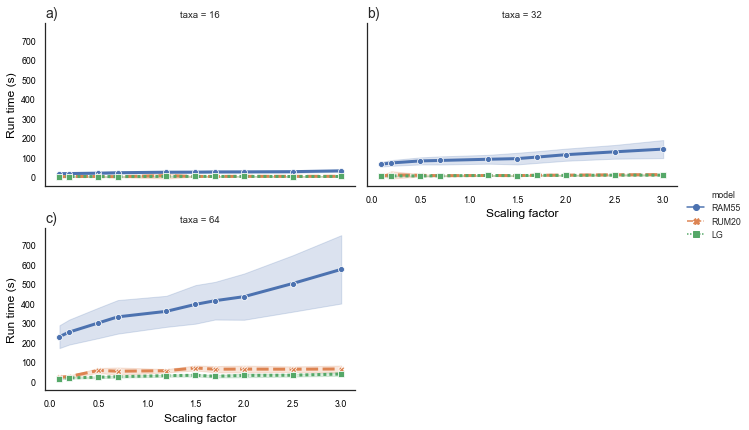

In [47]:
g = sb.relplot(x="f", y="run_time", col="taxa", col_wrap=2, hue="model",
               style="model", ci="sd", lw=3, markers=True, kind="line", 
               height=3, aspect=1.6, data=reshaped_df)

for ax, label in zip(g.axes.flatten(), ["a)", "b)", "c)"]):
    ax.set_xlabel('Scaling factor', fontsize=12)
    ax.set_ylabel('Run time (s)', fontsize=12)
    ax.set_title(label, loc="left", fontsize=14)

fig = g.fig
plt.savefig("Figures/ALLx200x100_run_time.svg", 
            format='svg', bbox_inches='tight', dpi=fig.dpi)
plt.savefig("Figures/ALLx200x100_run_time.pdf", 
            format='pdf', bbox_inches='tight', dpi=fig.dpi)

# Conclusions and Next Steps
Summarize findings here